# PID Tuning using GA

In [46]:
import numpy as np
import control
import matplotlib.pyplot as plt
from pymoo.algorithms.soo.nonconvex.ga import GA
from pymoo.operators.crossover.pntx import PointCrossover
from pymoo.operators.mutation.pm import PolynomialMutation
from pymoo.operators.repair.rounding import RoundingRepair
from pymoo.operators.sampling.rnd import FloatRandomSampling
from pymoo.core.problem import Problem
from pymoo.optimize import minimize

### Define objective function

In [47]:
def objective_function(t, error, criterion):

    if criterion == 1:
        # ITAE (Integral Time Absolute Error)
        ITAE = np.trapz(t, t*error)
        objfnc= ITAE
    elif criterion == 2:
        # ITSE (Integral Time Square Error)
        ITSE = np.trapz(t, t*error**2)
        objfnc= ITSE
    elif criterion == 3:
        # IAE (Integral Absolute Error)
        IAE =  np.trapz(t, error)
        objfnc= IAE
    elif criterion == 4:
        # ISE (Integral Squared Error)
        ISE = np.trapz(t, error**2)
        objfnc= ISE
        
    return objfnc

### Define the optimization problem for PID controller

$TF=\frac{K_ds^2+K_ps+K_i}{s^3+(K_d+10)s^2+(K_p+20)s+K_i}$

In [48]:
# Transfer function of the PID controller
def transfer_function(Kp,Ki,Kd):
    num = np.array([Kd,Kp,Ki])
    den = np.array([1,(Kd+30),(Kp+10),Ki])
    T = control.tf(num, den)
    t, y = control.step_response(T)
    return T, t, y

In [49]:
class PIDProblem(Problem):

    def __init__(self):
        super().__init__(n_var=3,
                         n_obj=1,
                         n_constr=0,
                         xl=0,
                         xu=100, vtype=float)    

    def _evaluate(self, X, out, *args, **kwargs):
        f = np.zeros((X.shape[0], 1))
        for i, params in enumerate(X):
            Kp, Ki, Kd = params
            _, t, y =transfer_function(Kp,Ki,Kd)
            error = 1 - y
            f[i]=objective_function(t, np.abs(error), 1)
        out["F"] = f

### Define the solver and run for the PID problem

In [50]:
problem = PIDProblem()

algorithm = GA(
    pop_size=50,
    sampling=FloatRandomSampling(),
    crossover=PointCrossover(prob=0.8, n_points=2),
    mutation = PolynomialMutation(prob=0.3, repair=RoundingRepair()),
    eliminate_duplicates=True
)

res = minimize(problem, algorithm, ('n_gen', 70), seed=1, verbose=True)

n_gen  |  n_eval  |     f_avg     |     f_min    
     1 |       50 | -1.498016E+01 | -2.550193E+02
     2 |      100 | -3.217359E+01 | -2.550193E+02
     3 |      150 | -5.457635E+01 | -2.550193E+02
     4 |      200 | -8.868815E+01 | -2.550193E+02
     5 |      250 | -2.080708E+02 | -7.082970E+02
     6 |      300 | -3.312601E+02 | -7.555149E+02
     7 |      350 | -4.964648E+02 | -8.593941E+02
     8 |      400 | -6.963980E+02 | -8.593941E+02
     9 |      450 | -7.302059E+02 | -8.593941E+02
    10 |      500 | -7.693020E+02 | -8.877248E+02
    11 |      550 | -8.070761E+02 | -8.877248E+02
    12 |      600 | -8.312516E+02 | -9.727170E+02
    13 |      650 | -8.590158E+02 | -9.727171E+02
    14 |      700 | -8.858355E+02 | -9.821608E+02
    15 |      750 | -9.105777E+02 | -9.821608E+02
    16 |      800 | -9.347536E+02 | -1.001048E+03
    17 |      850 | -9.598736E+02 | -1.010492E+03
    18 |      900 | -9.808383E+02 | -1.010492E+03
    19 |      950 | -9.917930E+02 | -1.010492E+03


### Print the results

In [51]:
best_params = res.X
print("Optimal PID controller parameters:")
print("Kp =", best_params[0])
print("Ki =", best_params[1])
print("Kd =", best_params[2])

Optimal PID controller parameters:
Kp = 100
Ki = 1
Kd = 100


### Visualize the time response

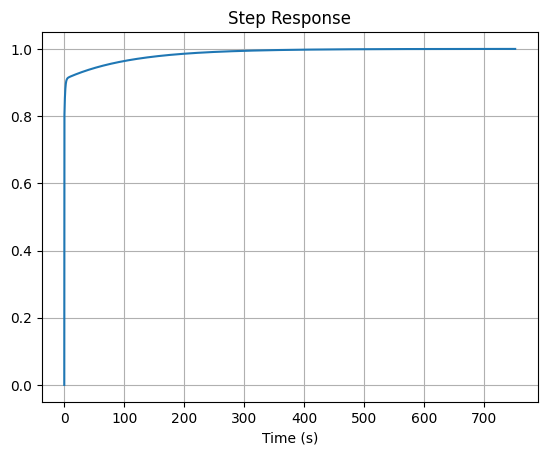

In [56]:
Kp = best_params[0]
Ki = best_params[1]
Kd = best_params[2]

T, t, y =transfer_function(Kp,Ki,Kd)

plt.plot(t,y)
plt.title("Step Response")
plt.xlabel("Time (s)")
plt.grid()
# plt.savefig('CH08_F19.png', format='png', dpi=300)

### Step response characteristics (Rise time, Settling Time, Peak and others)

In [53]:
control.step_info(T)

{'RiseTime': 2.8566525226803194,
 'SettlingTime': 164.18234498773205,
 'SettlingMin': 0.9012817516137268,
 'SettlingMax': 1.0,
 'Overshoot': 0,
 'Undershoot': 0,
 'Peak': 0.9999096338388097,
 'PeakTime': 751.6003137304692,
 'SteadyStateValue': 1.0}

### Check stability  [Optional]

<i>Asymptotically Stable System</i>
* All the poles ley in the left half plane
* All real parts of the pooles are negative

<i>Marginally Stable System</i>
* Poles coincide in the imaginary axis

<i>Unstable System</i>
* At least one pole lies in the right half plane (has real part greater than zero). 


p = [-1.29148326e+02+0.j -8.42483158e-01+0.j -9.19072964e-03+0.j]


(array([-1.29148326e+02+0.j, -8.42483158e-01+0.j, -9.19072964e-03+0.j]),
 array([-0.98989795+0.j, -0.01010205+0.j]))

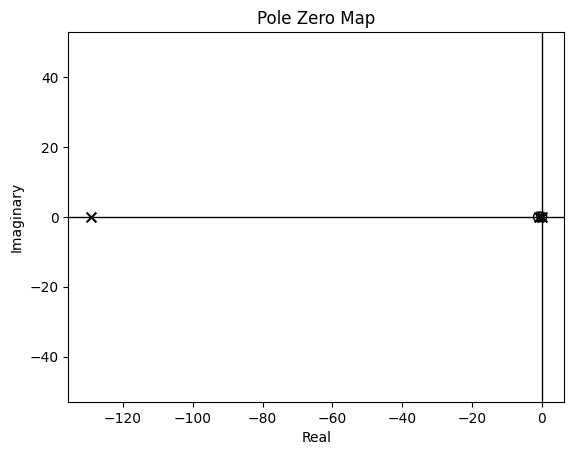

In [54]:
# Poles
p = control.pole(T)
print ('p =', p)

control.pzmap(T)